In [5]:
# For Matrix Operations
import sklearn
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [6]:
def persistence(array, dimension=None):
  height, width = array.shape
  cubeComplex = gudhi.CubicalComplex(
      dimensions = [width,height],
      top_dimensional_cells = 255 - array.flatten()
  )
 
  if dimension == None:
    persistence = cubeComplex.persistence()
  else:
    cubeComplex.compute_persistence()
    persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
    
  return persistence
def Get_Vinyard(f, g, D):
##########
    # input:
        # f and g by which you want to interpolate using straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal intervals from 0 to 100
    ts = np.linspace(0,1,101)
    # creates homology from f to g using these intervals
    hs = np.array([(t * f) + (1-t) * g for t in ts])
    
    PDD = [persistence(h,dimension = D) for h in hs]

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDD[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDD[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDD[i-1], PDD[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")

        for k in [l for l in ends]: 
            if k >= len(PDD[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDD[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDD[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)




    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]


    mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, hs
def Plot_Vinyard(res, mx, hs):


    gos = []

    # x axis is time
    # y axis is birth time
    # z axis is death time
    for vine in res:
        vine = np.array(vine)

        gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
            size=2,
        ),
        line=dict(
            width=2
        )))


    xs = np.linspace(0, mx, 10)
    zs = np.linspace(0, 1, 10)
    xss, zss = np.meshgrid(xs, zs)
    gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
    fig = go.Figure(data=gos)

    fig.update_layout(
        width=800,
        height=700,
        scene=dict(
        xaxis_title='T (homotopy)',
        yaxis_title='Birth',
        zaxis_title='Death'
    )
    )

    fig.show()


### Checkerboard Generation

Here I create two 28 x 28 checkerboards. One has the even squares colored. The other has the odd squares colored

this is f


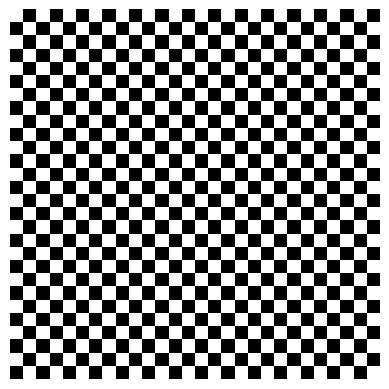

this is g


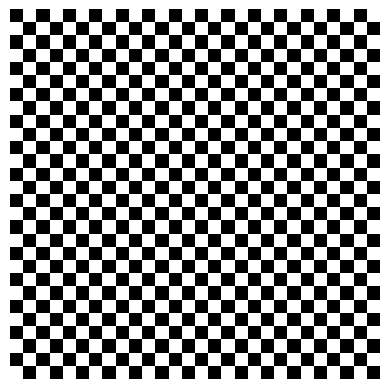

In [7]:
f = np.zeros((28, 28))

f[::2, ::2] = 100  
f[1::2, 1::2] = 100  


print('this is f')
plt.imshow(f, cmap = 'gray', vmin = 0, vmax = 100)
plt.axis('off') 
plt.show()

g = f
g = np.ones_like(f) * 100 -f
print('this is g')
plt.imshow(g, cmap = 'gray', vmin = 0, vmax = 100)
plt.axis('off')  
plt.show()

### Homotopy

Defining a straight line homotopy to take us from one checkerboard to ther.

this is f


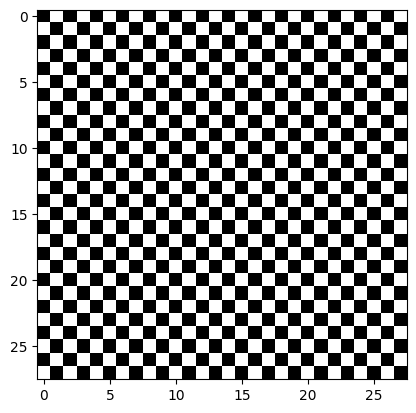

time step 30


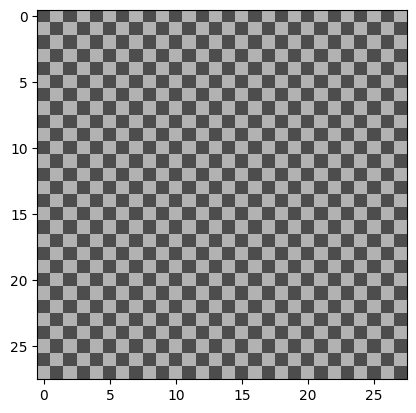

time step 60


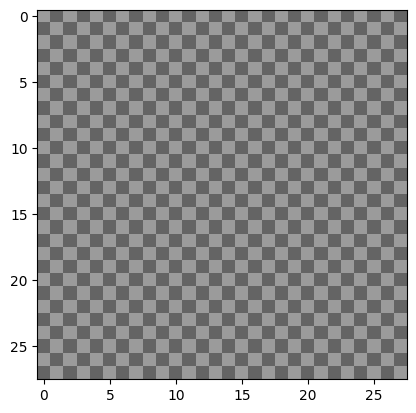

this is g


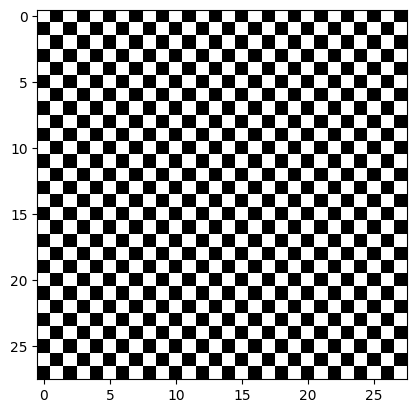

In [8]:
ts = np.linspace(0,1,100)
hs = np.array([(t * f) + (1-t) * g for t in ts])

print('this is f')
plt.imshow(hs[0], cmap = 'gray', vmin = 0, vmax = 100)
plt.show()

print('time step 30')
plt.imshow(hs[30], cmap = 'gray', vmin = 0, vmax = 100)
plt.show()


print('time step 60')
plt.imshow(hs[60], cmap = 'gray', vmin = 0, vmax = 100)
plt.show()


print('this is g')
plt.imshow(hs[99], cmap = 'gray', vmin = 0, vmax = 100)
plt.show()


### Vinyard Generation
Here I plot the vinyard generated from our homotopy as well as the persistence diagrams for f and g. 

Note that the persistence diagrams are identical, so our Wasserstein distance should be low. Additionally, note the two main vines in the vinyard. These contribute to the vinyard distance we see below.

H1 persistence of g


/opt/homebrew/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


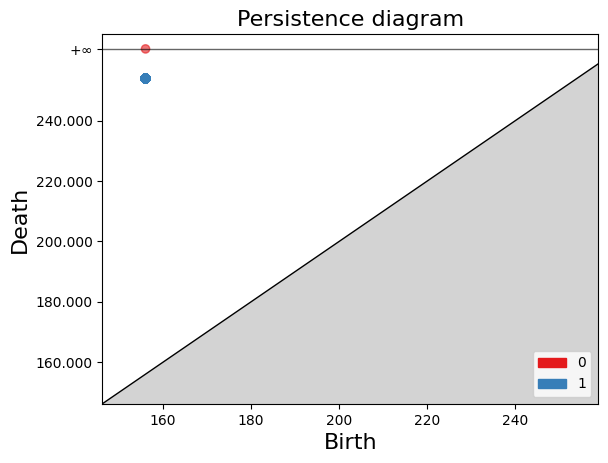

H1 persistence of f


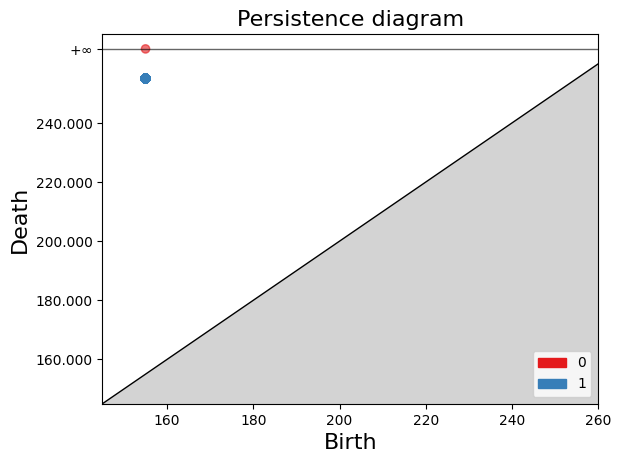

In [9]:
Checkerboard_Vinyard = Get_Vinyard(f,g,1)

print('H1 persistence of g')
gudhi.plot_persistence_diagram(persistence(Checkerboard_Vinyard[2][99]))
plt.show()
# plotting persistence diagram of f
print('H1 persistence of f')
gudhi.plot_persistence_diagram(persistence(Checkerboard_Vinyard[2][0]))
plt.show()

Plot_Vinyard(Checkerboard_Vinyard[0],Checkerboard_Vinyard[1],Checkerboard_Vinyard[2])



### Distance Calculation

As expected we get zero for our wasserstein distance. However, vinyard distance remains high, showing that there is a noticable difference between our two checkerboards. 

In [14]:
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid)
            
            v += f(D)*l
            L += l

        v *= g(L)
        V += v

    return V

def fD(D):
    return D/100

def fL(L):
    return 1


In [13]:
PD_First_Frame = persistence(np.array(Checkerboard_Vinyard[0][0]), dimension = 1)
PD_Last_Frame = persistence(np.array(Checkerboard_Vinyard[0][99]), dimension = 1)
Wasserstein_Distance = gudhi.hera.wasserstein_distance(PD_First_Frame, PD_Last_Frame)
print("Vinyard Distance:")
print(vdist(Checkerboard_Vinyard[0], fD, fL))
print("Wasserstein Distance:")
print(Wasserstein_Distance)

Vinyard Distance:
83.90511414531112
Wasserstein Distance:
0.0
